In [1]:
import warnings
warnings.filterwarnings('ignore')

import iris
import iris.plot as iplt
import iris.quickplot as qplt
from iris.experimental.equalise_cubes import equalise_attributes

import matplotlib.pyplot as plt

import glob
import numpy

In [2]:
%matplotlib inline

# Full field trends (i.e. lat, lon, depth)

In [3]:
ccsm_ghg_dedrifted_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/historicalGHG/yr/ocean/r1i1p1/thetao/latest/dedrifted/thetao_Oyr_CCSM4_historicalGHG_r1i1p1_1950-2005-trend_susan-grid.nc'
ccsm_ghg_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/historicalGHG/yr/ocean/r1i1p1/thetao/latest/thetao_Oyr_CCSM4_historicalGHG_r1i1p1_1950-2005-trend_susan-grid.nc'
canesm_ghg_dedrifted_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/historicalGHG/yr/ocean/r1i1p1/thetao/latest/dedrifted/thetao_Oyr_CanESM2_historicalGHG_r1i1p1_1950-2005-trend_susan-grid.nc'
canesm_ghg_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/historicalGHG/yr/ocean/r1i1p1/thetao/latest/thetao_Oyr_CanESM2_historicalGHG_r1i1p1_1950-2005-trend_susan-grid.nc'

In [4]:
def plot_lon_slice(infile, model, experiment, dedrifted=False):
    """Plot depth vs latitude for a given longitude"""
    
    cube = iris.load_cube(infile, 'sea_water_potential_temperature')

    plt.figure(figsize=(10, 10))
    
    plt.subplot(221)
    qplt.pcolormesh(cube.extract(iris.Constraint(longitude=2)), cmap='RdBu_r', vmax=0.025, vmin=-0.025)
    plt.title('2E')
    
    plt.subplot(222)
    qplt.pcolormesh(cube.extract(iris.Constraint(longitude=62)), cmap='RdBu_r', vmax=0.025, vmin=-0.025)
    plt.title('62E')
    
    plt.subplot(223)
    qplt.pcolormesh(cube.extract(iris.Constraint(longitude=122)), cmap='RdBu_r', vmax=0.025, vmin=-0.025)
    plt.title('122E')
    
    plt.subplot(224)
    qplt.pcolormesh(cube.extract(iris.Constraint(longitude=302)), cmap='RdBu_r', vmax=0.025, vmin=-0.025)
    plt.title('302E')
    
    title = 'temperature trend, 1950-2005 (%s, %s)' %(model, experiment)
    if dedrifted:
        title = 'dedrifted ' + title
        
    plt.suptitle(title)
    
    plt.show()

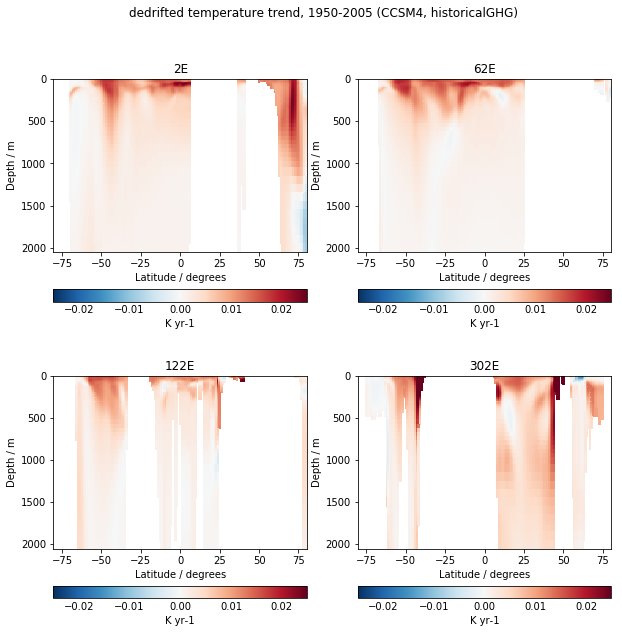

In [5]:
plot_lon_slice(ccsm_ghg_dedrifted_file, 'CCSM4', 'historicalGHG', dedrifted=True)

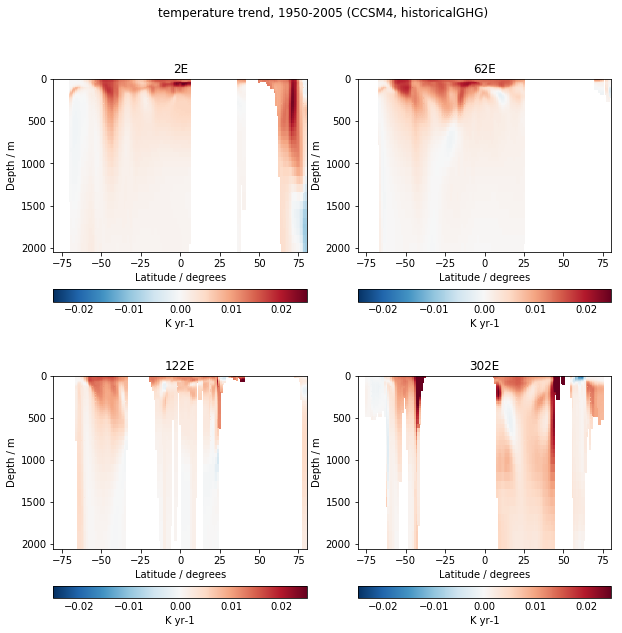

In [6]:
plot_lon_slice(ccsm_ghg_file, 'CCSM4', 'historicalGHG')

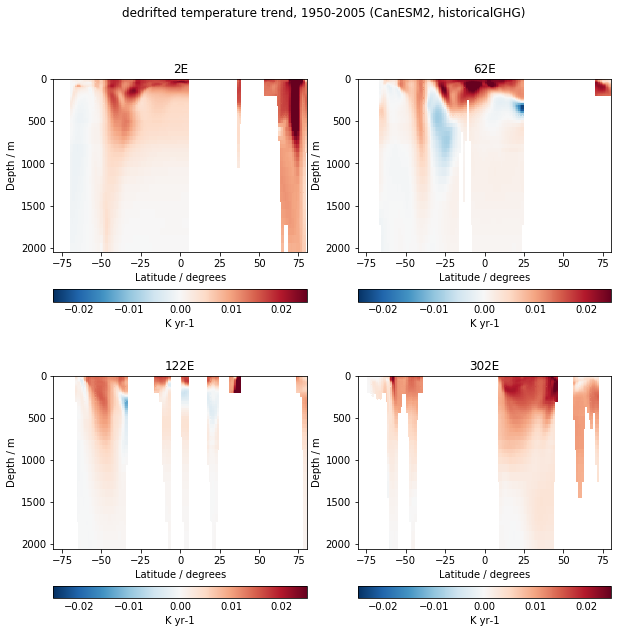

In [7]:
plot_lon_slice(canesm_ghg_dedrifted_file, 'CanESM2', 'historicalGHG', dedrifted=True)

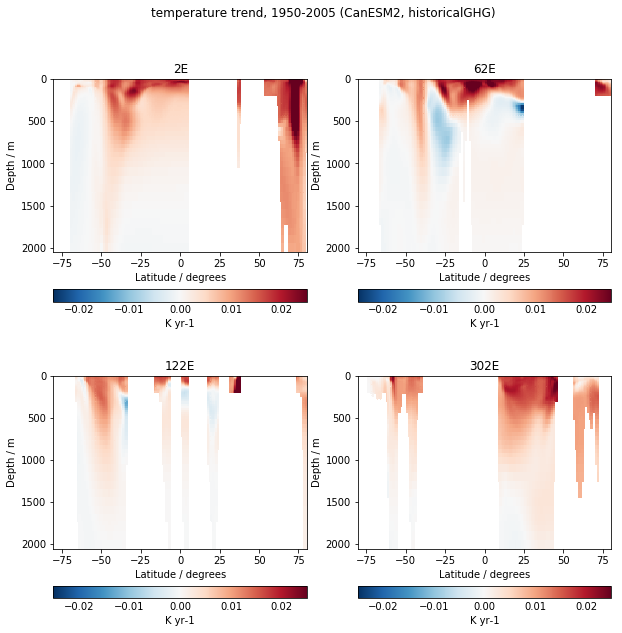

In [8]:
plot_lon_slice(canesm_ghg_file, 'CanESM2', 'historicalGHG')

# Zonal mean trends

In [13]:
ccsm_zonal_mean_ghg_dedrifted_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/historicalGHG/yr/ocean/r1i1p1/thetao/latest/dedrifted/thetao-zonal-mean_Oyr_CCSM4_historicalGHG_r1i1p1_1950-2005-trend_susan-grid.nc'
ccsm_zonal_mean_ghg_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/historicalGHG/yr/ocean/r1i1p1/thetao/latest/thetao-zonal-mean_Oyr_CCSM4_historicalGHG_r1i1p1_1950-2005-trend_susan-grid.nc'

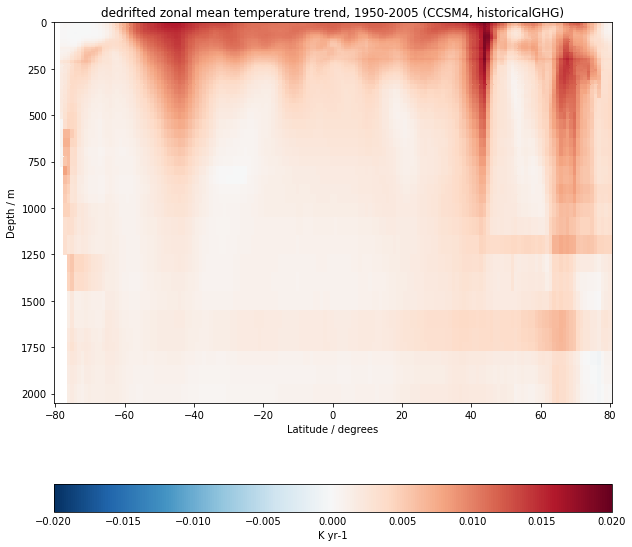

In [15]:
cube = iris.load_cube(ccsm_zonal_mean_ghg_dedrifted_file, 'sea_water_potential_temperature')
plt.figure(figsize=(10, 10))
qplt.pcolormesh(cube, cmap='RdBu_r', vmax=0.02, vmin=-0.02)
plt.title('dedrifted zonal mean temperature trend, 1950-2005 (CCSM4, historicalGHG)')
plt.show()

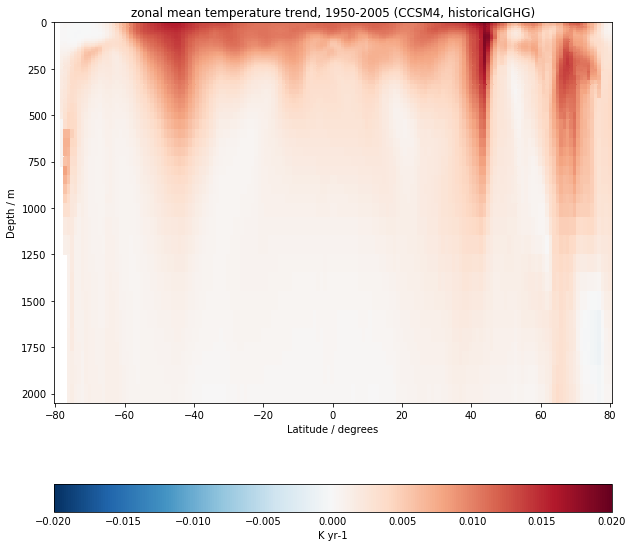

In [16]:
cube = iris.load_cube(ccsm_zonal_mean_ghg_file, 'sea_water_potential_temperature')
plt.figure(figsize=(10, 10))
qplt.pcolormesh(cube, cmap='RdBu_r', vmax=0.02, vmin=-0.02)
plt.title('zonal mean temperature trend, 1950-2005 (CCSM4, historicalGHG)')
plt.show()

# Check cubic polynomial fit

In [3]:
def get_clean_data(data):
    """Remove the crazy values from a timeseries."""

    std = numpy.std(data)
    mean = numpy.mean(data)
    
    clean_data = numpy.where(data > mean + 3*std, mean, data)
    clean_data = numpy.where(clean_data < mean - 3*std, mean, clean_data)
    
    return clean_data
    

def create_polynomial(xdata, data, deg=3, coefficients=None):
    """Create a polynomial given the x-values and coefficients"""
    
    if not coefficients:
        coefficients = numpy.polynomial.polynomial.polyfit(xdata, data, deg)
    
    poly = coefficients[0]
    for index, coef in enumerate(coefficients[1:]):
        poly = poly + coef * xdata**(index + 1)
        
    return poly


def plot_control(model, depth, lat=-50, lon=62, ylim=None, plot=True):
    """Plot the control data and cubic fit"""
    
    control_filenames = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/piControl/yr/ocean/r1i1p1/thetao/latest/thetao_Oyr_%s_piControl_r1i1p1_*_susan-grid.nc' %(model, model)   
    control_files = glob.glob(control_filenames)
    coefficient_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/piControl/yr/ocean/r1i1p1/thetao/latest/thetao-coefficients_Oyr_%s_piControl_r1i1p1_all_susan-grid.nc' %(model, model)
    
    lon_constraint = iris.Constraint(longitude=lon)
    lat_constraint = iris.Constraint(latitude=lat)
    depth_constraint = iris.Constraint(depth=depth)
    
    cube_list = iris.load(control_files, 'sea_water_potential_temperature')
    iris.util.unify_time_units(cube_list)
    equalise_attributes(cube_list)
    cube = cube_list.concatenate_cube()
    cube = cube.extract(lon_constraint & lat_constraint & depth_constraint)
    
    coefficient_a_cube = iris.load_cube(coefficient_file, 'coefficient a' & lon_constraint & lat_constraint & depth_constraint)
    coefficient_b_cube = iris.load_cube(coefficient_file, 'coefficient b' & lon_constraint & lat_constraint & depth_constraint)
    coefficient_c_cube = iris.load_cube(coefficient_file, 'coefficient c' & lon_constraint & lat_constraint & depth_constraint)
    coefficient_d_cube = iris.load_cube(coefficient_file, 'coefficient d' & lon_constraint & lat_constraint & depth_constraint)
    
    x_data = cube.coord('time').points
    clean_data = get_clean_data(cube.data)
    
    aval = float(coefficient_a_cube.data)
    bval = float(coefficient_b_cube.data)
    cval = float(coefficient_c_cube.data)
    dval = float(coefficient_d_cube.data)
    orig_cubic = create_polynomial(x_data, cube.data, coefficients=[aval, bval, cval, dval])
    check_cubic = create_polynomial(x_data, clean_data, deg=3)
    orig_quadratic = create_polynomial(x_data, clean_data, deg=2)
    orig_line = create_polynomial(x_data, clean_data, deg=1)
    
    if plot:   
        fig = plt.figure(figsize=[18, 7])
        ntimes = cube.shape[0]
        xvals = numpy.arange(ntimes)
        plt.plot(xvals, cube.data, label='data', color='0.5')
        plt.plot(xvals, orig_cubic, label='file cubic', color='green', linestyle='--')
        plt.plot(xvals, orig_quadratic, label='quadratic', color='blue', linestyle='--')
        plt.plot(xvals, orig_line, label='line', color='orange', linestyle='--')
        plt.plot(xvals, check_cubic, label='check cubic', color='green', linestyle='-.')
        
        #plt.plot(xvals, clean_data, label='clean_data', linestyle='None', marker='o', color='0.5')
        #plt.plot(xvals, clean_cubic, label='clean cubic', color='green', linestyle=':')
        #plt.plot(xvals, clean_quadratic, label='clean quadratic', color='blue', linestyle=':')
        #plt.plot(xvals, clean_line, label='clean line', color='orange', linestyle=':')
        
        plt.legend()
        plt.ylabel('temperature (K)')
        plt.xlabel('year')
        plt.title('%s, depth: %sm, lat: %s, lon: %s' %(model, str(depth), str(lat), str(lon)))
        if ylim:
            plt.ylim(ylim)

        plt.show()
    else:
        return cube, clean_data, x_data, [aval, bval, cval, dval]

### CanESM2

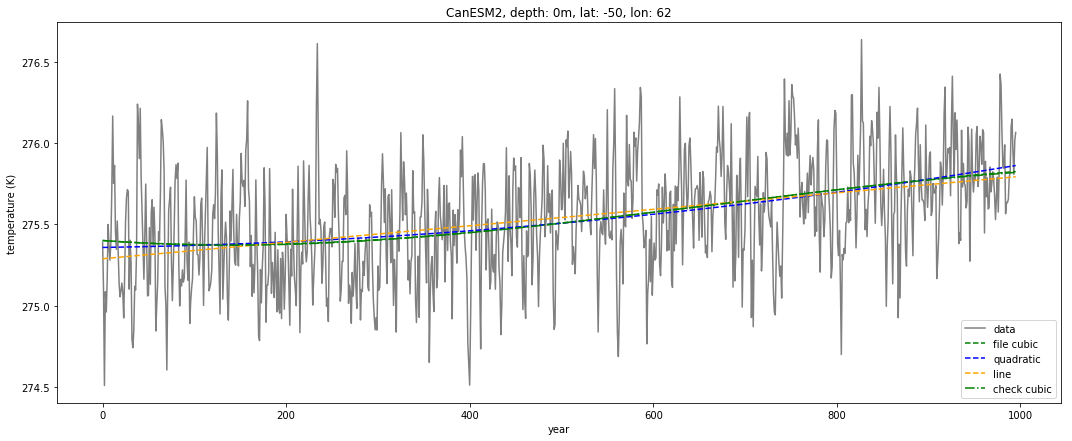

In [4]:
plot_control('CanESM2', 0)

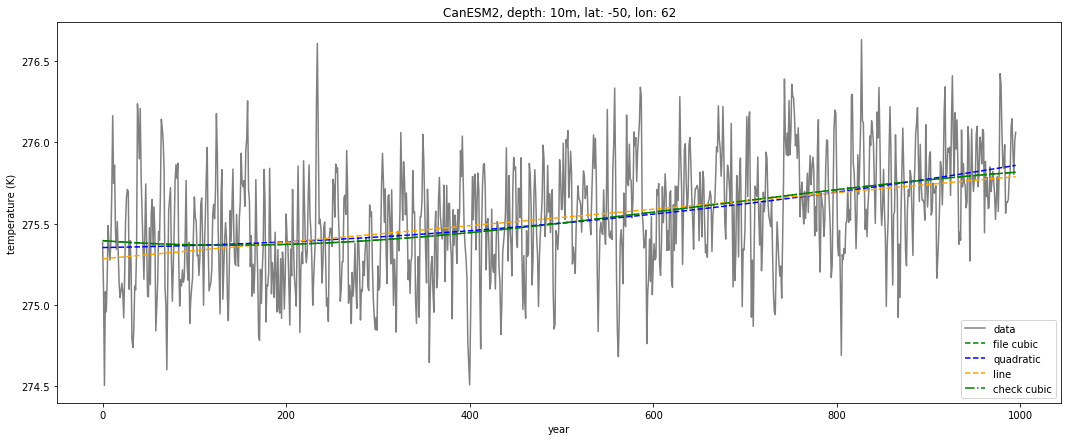

In [12]:
plot_control('CanESM2', 10)

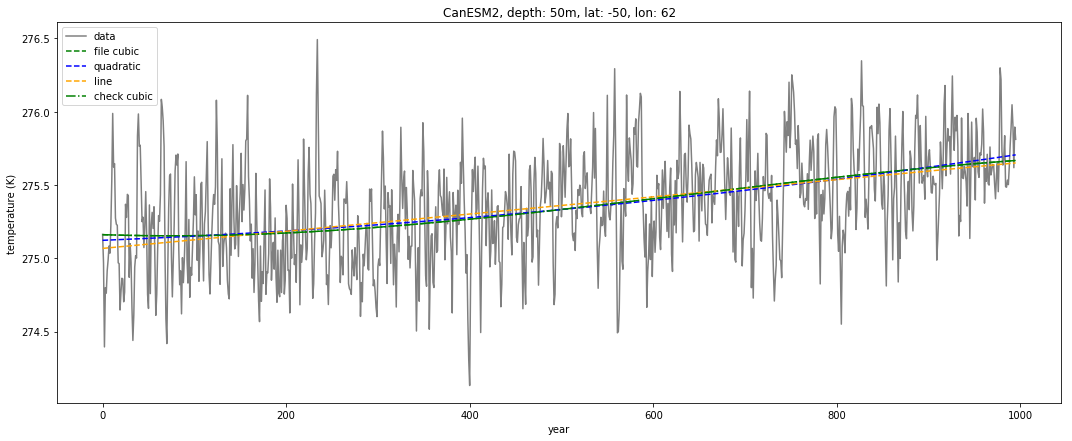

In [13]:
plot_control('CanESM2', 50)

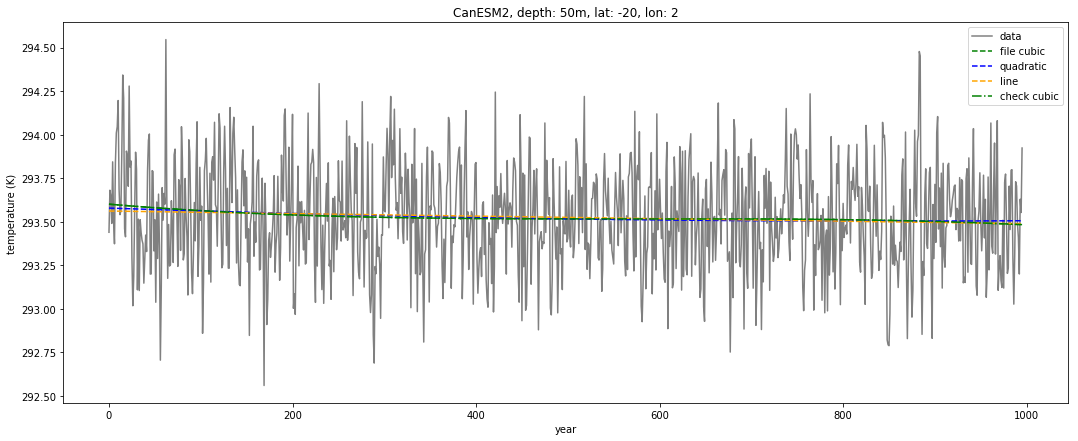

In [14]:
plot_control('CanESM2', 50, lat=-20, lon=2)

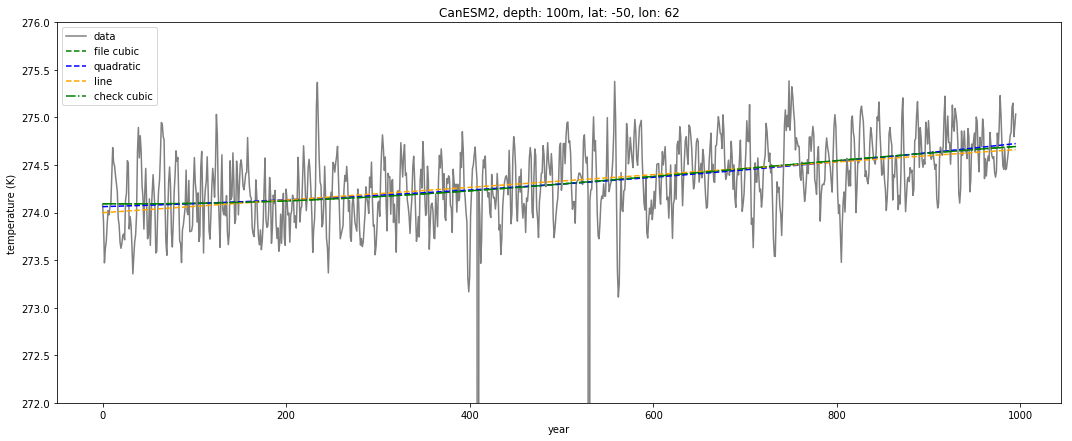

In [15]:
plot_control('CanESM2', 100, ylim=[272, 276])

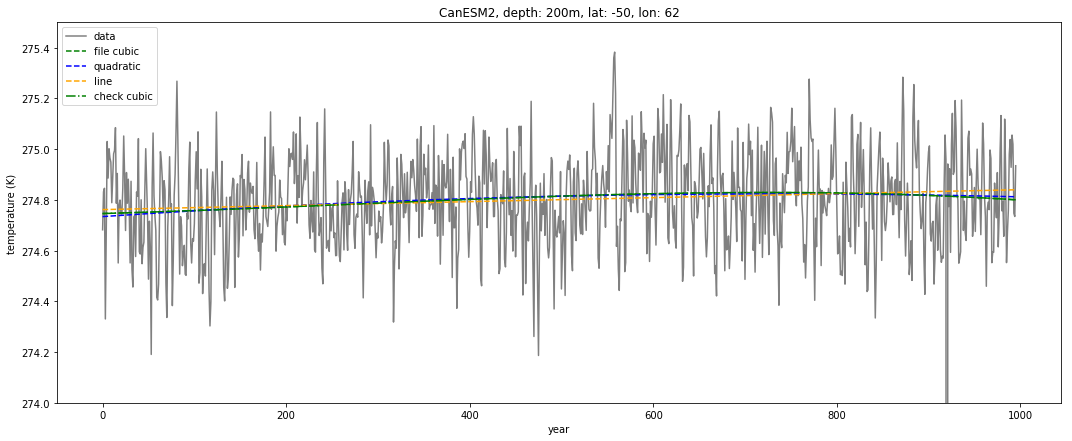

In [16]:
plot_control('CanESM2', 200, ylim=[274, 275.5])

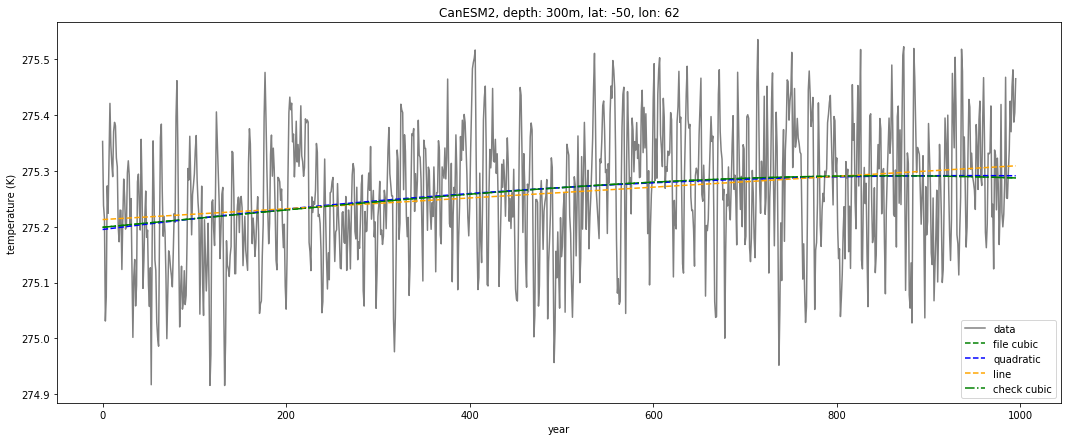

In [17]:
plot_control('CanESM2', 300)

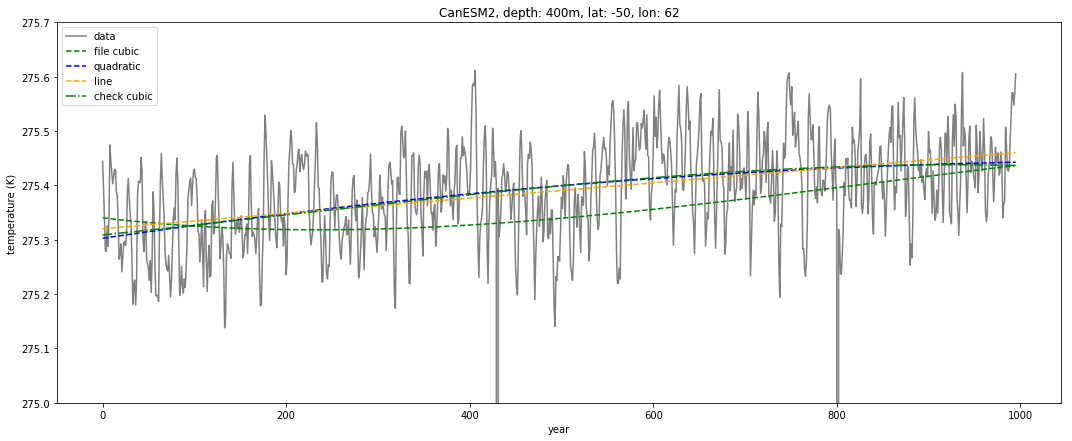

In [5]:
plot_control('CanESM2', 400, ylim=[275, 275.7])

In [6]:
test_cube, test_clean_data, xdata, coeffs = plot_control('CanESM2', 400, ylim=[275, 275.7], plot=False)

In [7]:
coeffs

[275.38756105323864,
 -1.035686701281121e-06,
 4.4321418207438375e-12,
 -4.047360456044438e-18]

In [8]:
numpy.polynomial.polynomial.polyfit(xdata, test_clean_data, 3)

array([ 2.75282256e+02,  3.86054233e-07,  1.00006895e-12, -2.48125684e-18])

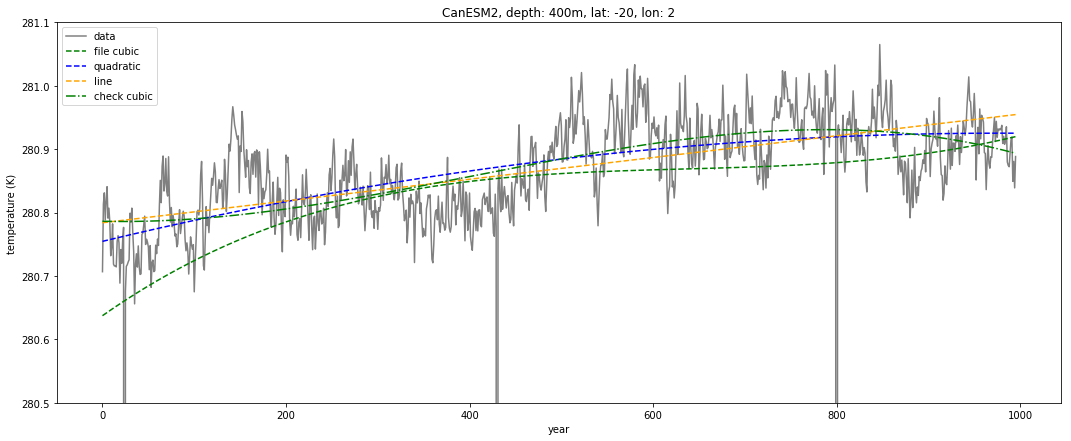

In [9]:
plot_control('CanESM2', 400, ylim=[280.5, 281.1], lat=-20, lon=2)

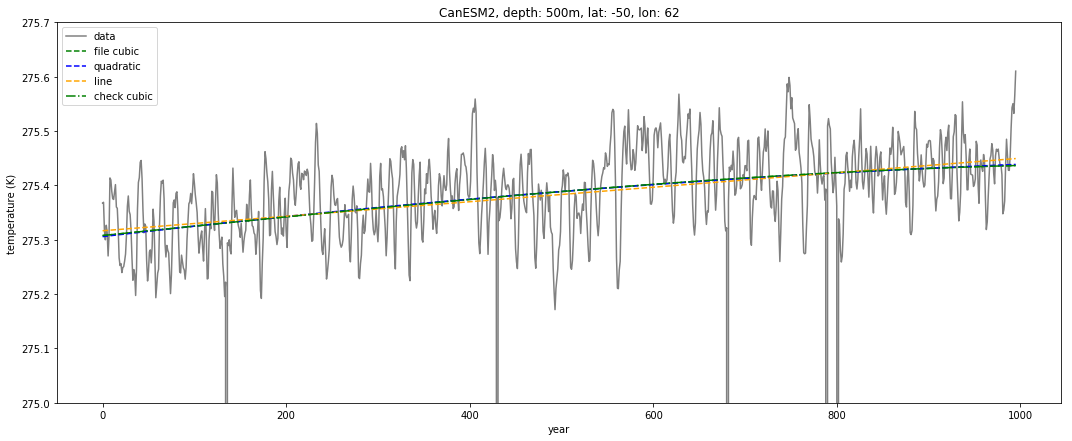

In [10]:
plot_control('CanESM2', 500, ylim=[275, 275.7])

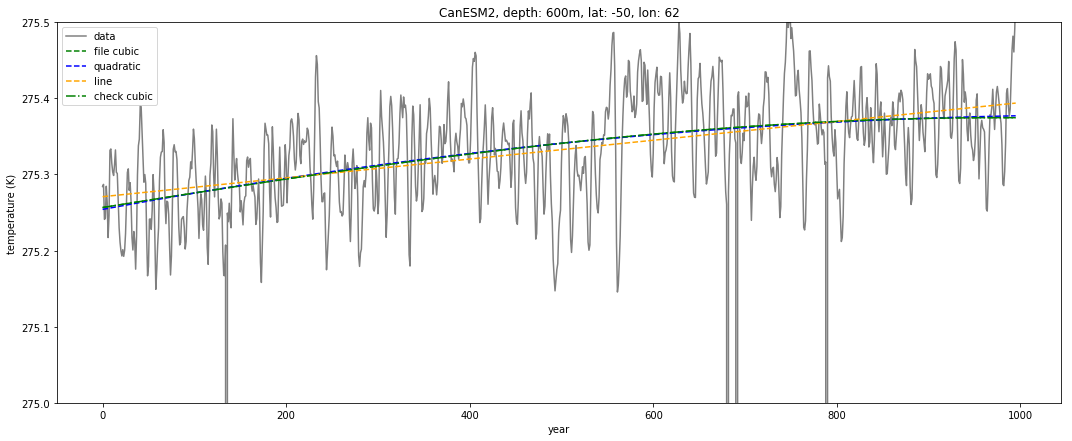

In [20]:
plot_control('CanESM2', 600, ylim=[275, 275.5])

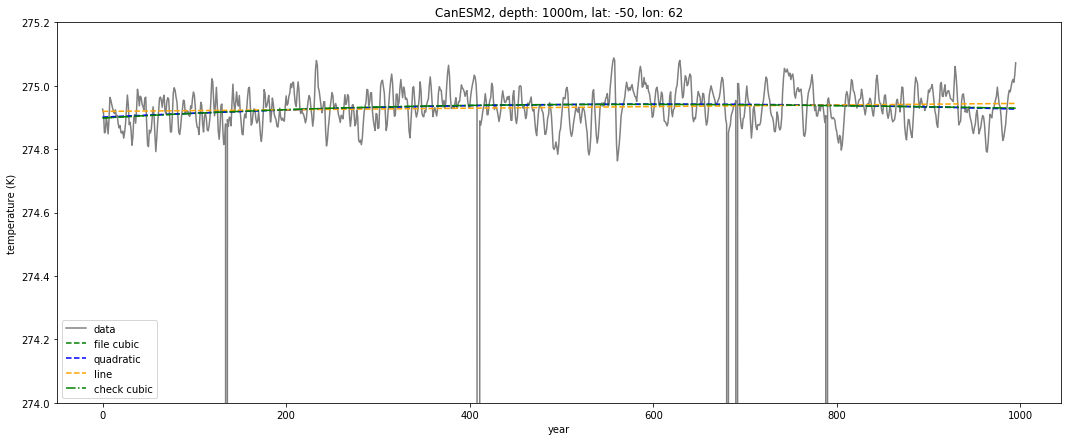

In [21]:
plot_control('CanESM2', 1000, ylim=[274, 275.2])

### CCSM4

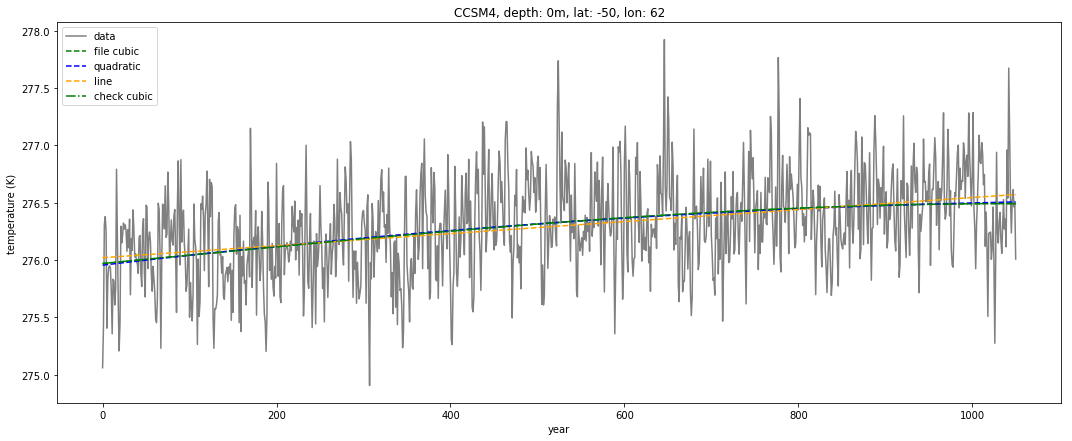

In [11]:
plot_control('CCSM4', 0)

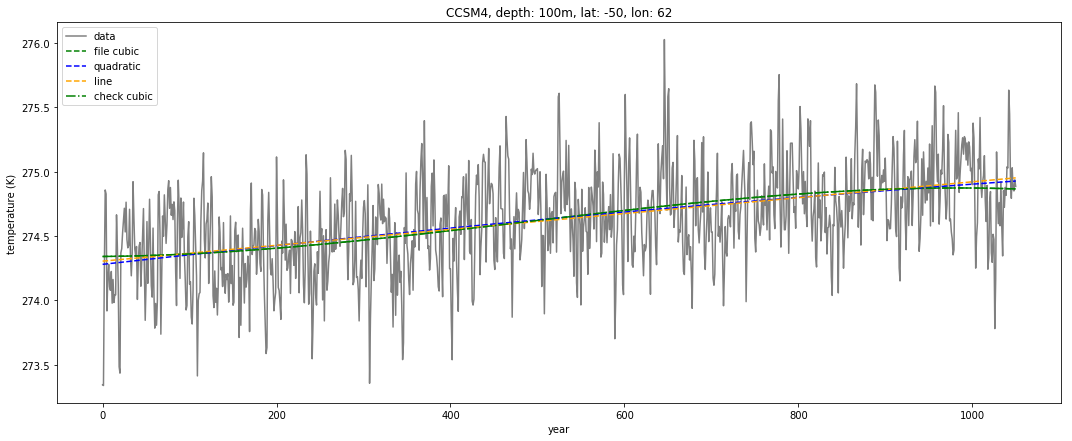

In [12]:
plot_control('CCSM4', 100)

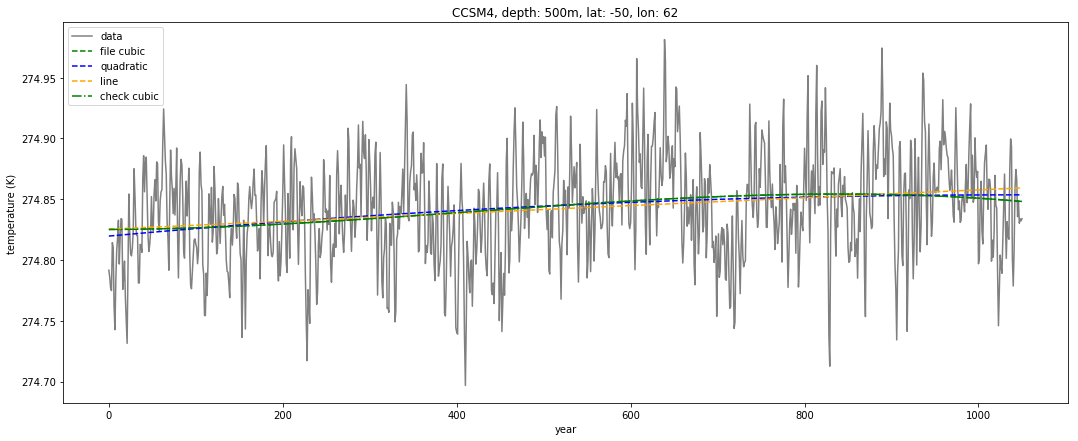

In [13]:
plot_control('CCSM4', 500)

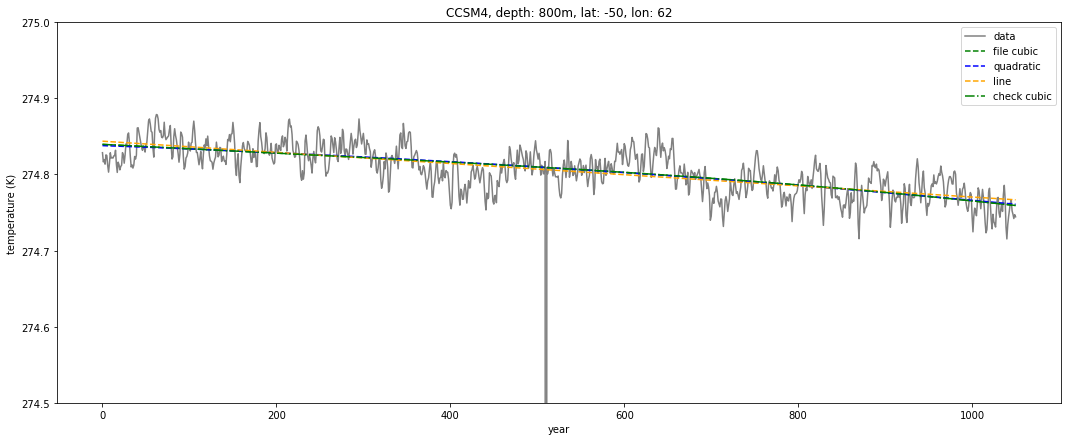

In [14]:
plot_control('CCSM4', 800, ylim=[274.5, 275])

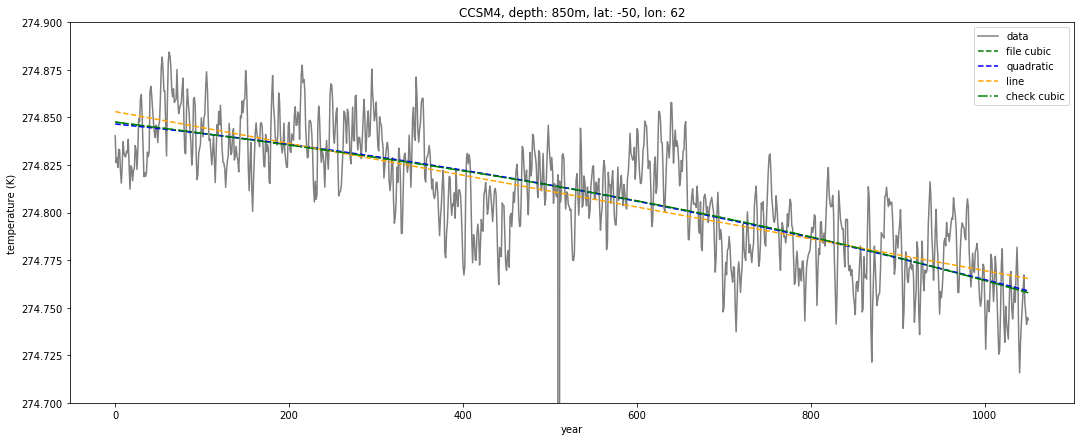

In [17]:
plot_control('CCSM4', 850, ylim=[274.7, 274.9])